Section 1: Data Loading and Preprocessing


In [1]:
from PIL import Image
import numpy as np
import os
from keras.utils import to_categorical

# Define image size
IMG_SIZE = 224

# Define categories and their labels
CATEGORIES = {"daisy": 0, "dandelion": 1, "roses": 2, "sunflowers": 3, "tulips": 4}

# Initialize X and y arrays
X = []
y = []
label_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}  # keep track of the number of images added for each category
categories = list(CATEGORIES.keys())  # get a list of category names
while True:
    stop = True
    for category in categories:
        if label_counts[CATEGORIES[category]] < len(os.listdir(os.path.join("small_flower_dataset", category))):
            # Load the next image and add it to X and y
            image_path = os.path.join("small_flower_dataset", category, os.listdir(os.path.join("small_flower_dataset", category))[label_counts[CATEGORIES[category]]])
            image = Image.open(image_path).resize((IMG_SIZE, IMG_SIZE))
            image_array = np.array(image)
            X.append(image_array)
            y.append(CATEGORIES[category])
            label_counts[CATEGORIES[category]] += 1
            stop = False
    if stop:
        break

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into train, Test and validation sets
split1 = int(len(X) * 0.6)  # 60% train
split2 = int(len(X) * 0.8)  # 20% validation

# Create the train set
X_train, y_train = X[:split1], y[:split1]

# Create the validation set
X_val, y_val = X[split1:split2], y[split1:split2]

# Create the test set
X_test, y_test = X[split2:], y[split2:]

num_classes = len(CATEGORIES)
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


Section 2: Model Training

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.utils import to_categorical

# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your own output layer with 5 neurons and a softmax activation function
x = Flatten()(base_model.output)
x = Dense(5, activation='softmax')(x)

# Create a new model that includes both the pre-trained base model and your custom output layer
model = Model(inputs=base_model.input, outputs=x)

# Define the optimizer
optimizer = SGD(learning_rate=0.01, momentum=0, nesterov=False)

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model on your own dataset
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))


Epoch 1/25
19/19 [==============================] - 24s 1s/step - loss: 135.5926 - accuracy: 0.2317 - val_loss: 86.7168 - val_accuracy: 0.3200
Epoch 2/25
19/19 [==============================] - 19s 1s/step - loss: 65.5541 - accuracy: 0.3800 - val_loss: 155.7802 - val_accuracy: 0.2200
Epoch 3/25
19/19 [==============================] - 20s 1s/step - loss: 72.0525 - accuracy: 0.3967 - val_loss: 32.9149 - val_accuracy: 0.4250
Epoch 4/25
19/19 [==============================] - 21s 1s/step - loss: 54.9125 - accuracy: 0.4350 - val_loss: 37.9450 - val_accuracy: 0.4050
Epoch 5/25
19/19 [==============================] - 20s 1s/step - loss: 18.2297 - accuracy: 0.6433 - val_loss: 52.9979 - val_accuracy: 0.3300
Epoch 6/25
19/19 [==============================] - 19s 1s/step - loss: 18.5258 - accuracy: 0.6450 - val_loss: 42.7435 - val_accuracy: 0.4650
Epoch 7/25
19/19 [==============================] - 19s 1s/step - loss: 10.2879 - accuracy: 0.7350 - val_loss: 32.8403 - val_accuracy: 0.4350
Epoc

Section 3: Prediction and Visualization

7/7 [==============================] - 6s 719ms/step


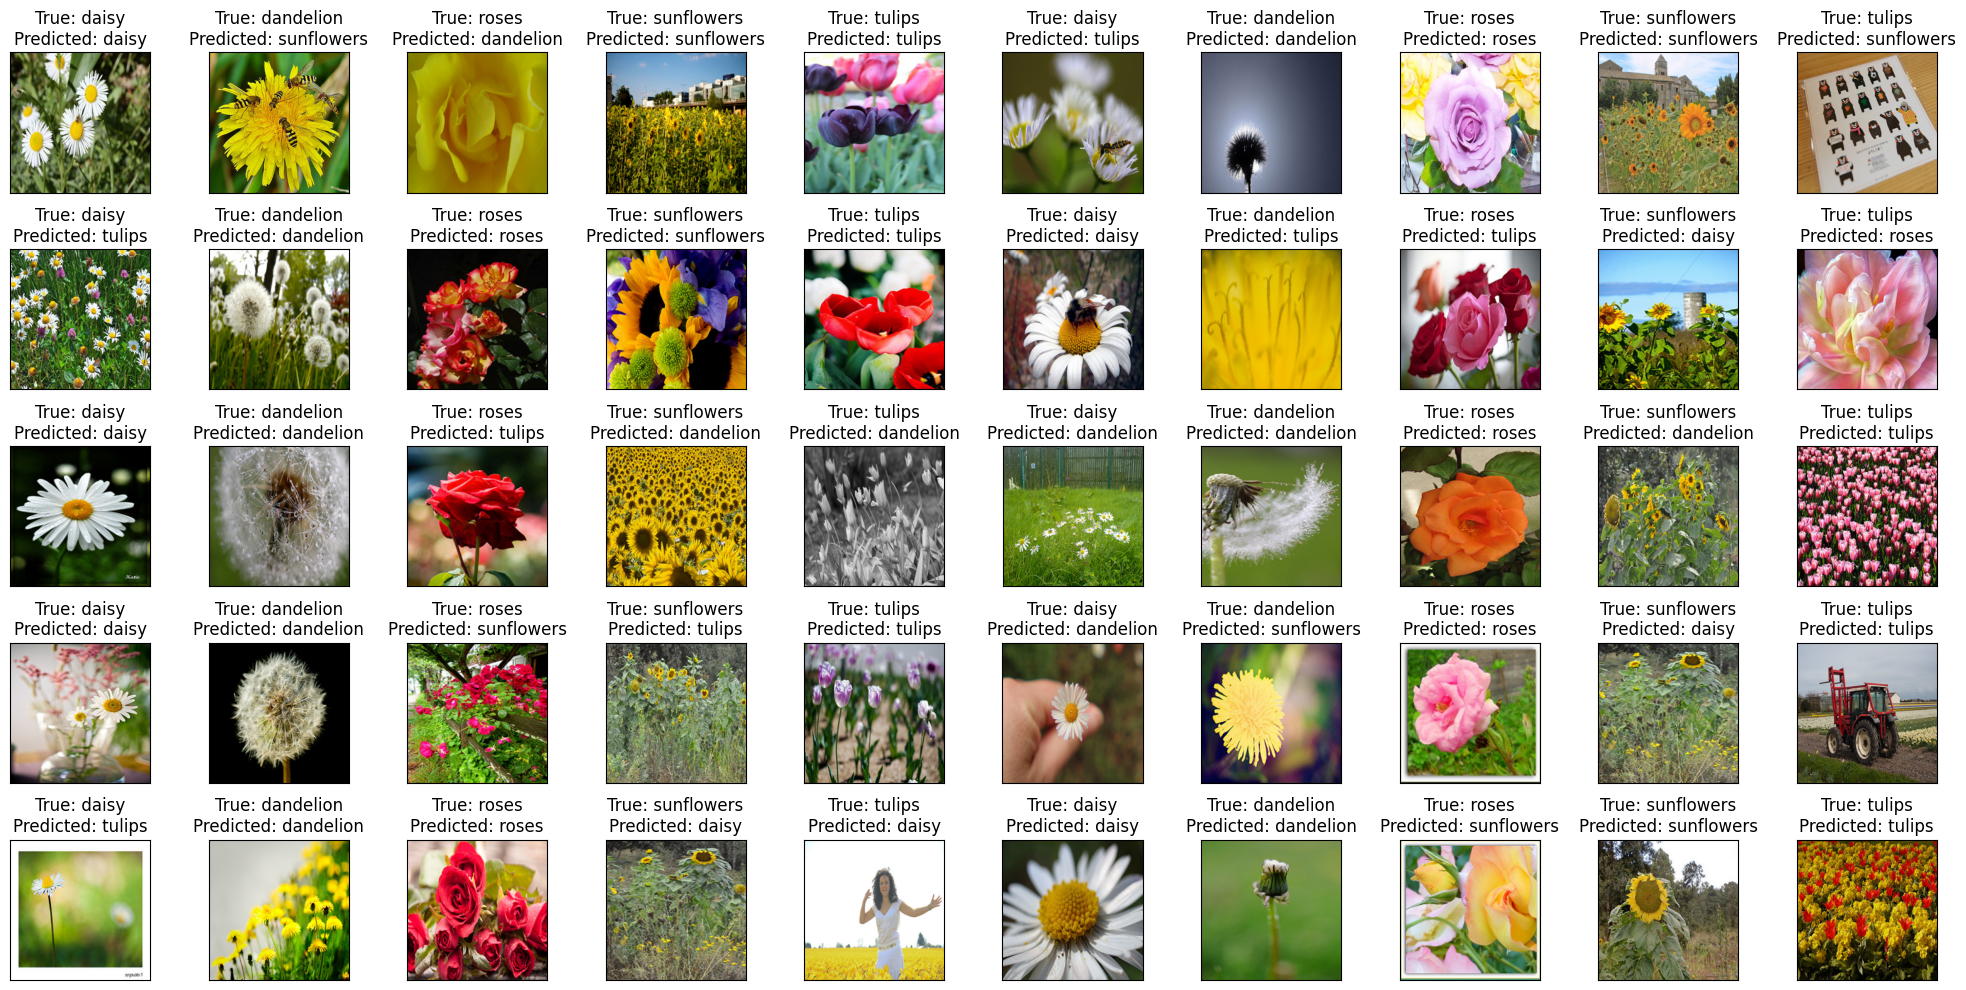

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Predict the first 10 results in X_test
y_pred = model.predict(X_test)
y_pred_labels = [list(CATEGORIES.keys())[list(CATEGORIES.values()).index(np.argmax(p))] for p in y_pred]

# Convert the one-hot encoded true labels to labels
y_true_labels = list(y_test)
true_labels = []
for label in y_true_labels:
    true_labels.append(list(CATEGORIES.keys())[list(CATEGORIES.values()).index(np.argmax(label))])

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(20,10))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"True: {true_labels[i]}\nPredicted: {y_pred_labels[i]}")

plt.tight_layout()
plt.show()


Section 4: Plotting Training and validation error and accuracy

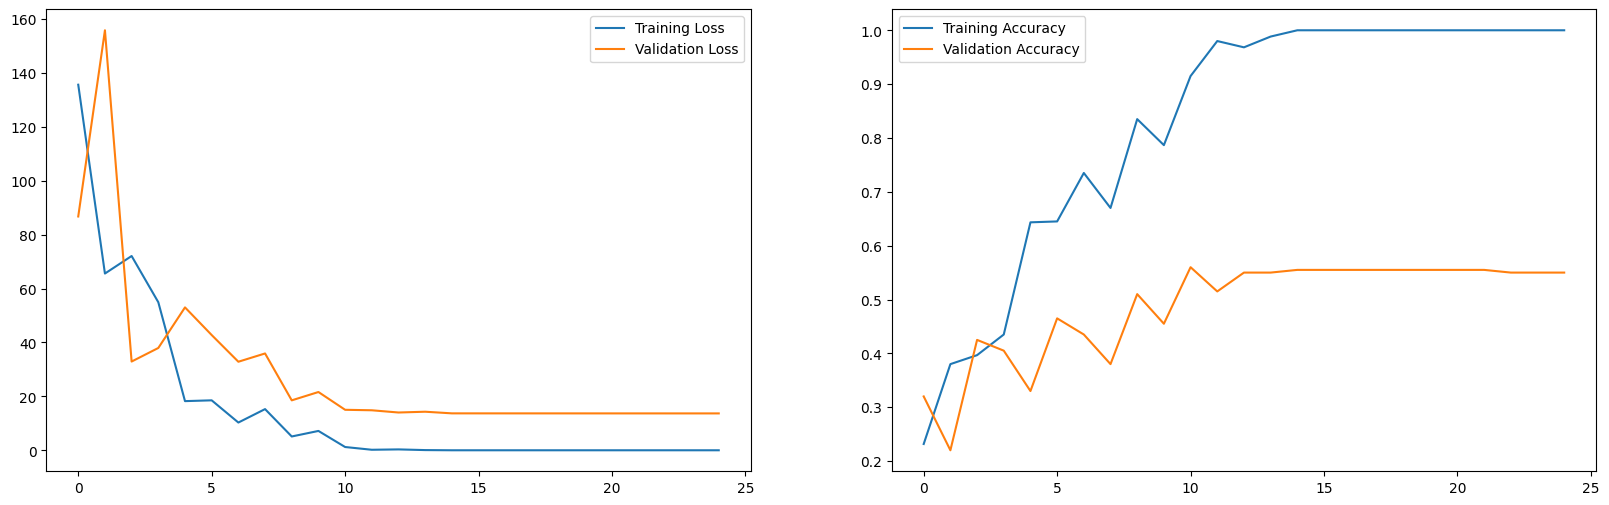

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label="Training Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
ax.legend()

Section 5: Finding Optimal Learning rate

Section 7: Plotting Training and validation accuracy and error of different Learning Rates

Section 8: Finding Optimal Momentum


Section 9: Accelerated learning via feature extraction of base model

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Extract features from the base model for training data
features_train = base_model.predict(X_train)

# Extract features from the base model for validation data
features_val = base_model.predict(X_val)

# Define the new model for feature extraction
model = Sequential()

# Flatten the output of the base model
model.add(Flatten(input_shape=base_model.output_shape[1:]))

# Add custom layers for feature extraction
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Add the output layer with 5 neurons for classification
model.add(Dense(5, activation='softmax'))

# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = SGD(learning_rate=0.01, momentum=0, nesterov=False)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the extracted features
history = model.fit(features_train, y_train, epochs=25, validation_data=(features_val, y_val))


7/7 [==============================] - 5s 658ms/step
Epoch 1/25
19/19 [==============================] - 2s 88ms/step - loss: 2.9945 - accuracy: 0.1900 - val_loss: 1.6211 - val_accuracy: 0.2000
Epoch 2/25
19/19 [==============================] - 1s 56ms/step - loss: 1.5895 - accuracy: 0.2650 - val_loss: 1.5899 - val_accuracy: 0.2700
Epoch 3/25
19/19 [==============================] - 1s 51ms/step - loss: 1.5575 - accuracy: 0.2733 - val_loss: 1.5562 - val_accuracy: 0.3150
Epoch 4/25
19/19 [==============================] - 1s 61ms/step - loss: 1.5061 - accuracy: 0.3617 - val_loss: 1.5137 - val_accuracy: 0.3350
Epoch 5/25
19/19 [==============================] - 1s 53ms/step - loss: 1.4512 - accuracy: 0.4150 - val_loss: 1.5090 - val_accuracy: 0.3450
Epoch 6/25
19/19 [==============================] - 1s 58ms/step - loss: 1.3475 - accuracy: 0.4767 - val_loss: 1.8840 - val_accuracy: 0.2000
Epoch 7/25
19/19 [==============================] - 1s 55ms/step - loss: 1.3851 - accuracy: 0.4417 - 

Section 10: Plotting Training and validation error and accuracy for accelerated learning

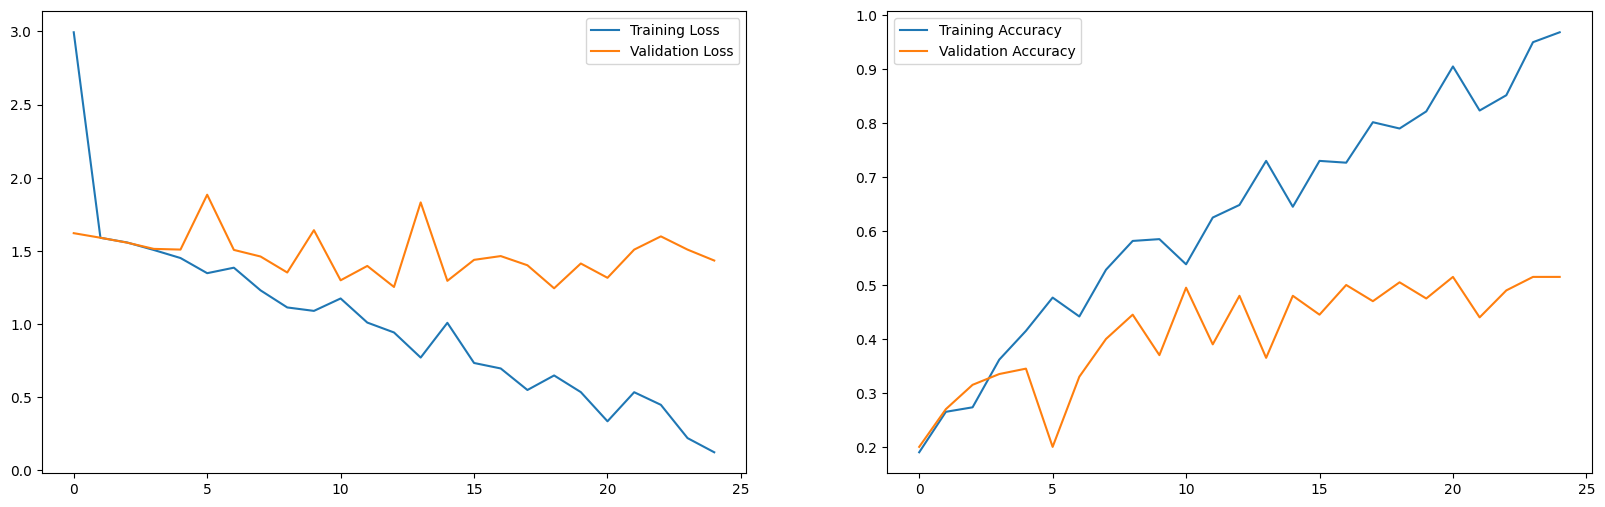

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label="Training Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
ax.legend()